In [1]:
# NEU surface defect



In [ ]:
# error type
'''
'Crazing'  -> Cr
'Inclusion'   ->  In
'Pitted Surface'  -> PS
'Patches'  -> Pa
'Rolled-in-scale'  ->  RS
'Scratches' -> Sc
'''

# directory structure
#./ml/train/cr   etc.     

#./ml/test

In [ ]:
#############################     CHECKING IMAGES    ################$##################

In [1]:

import pathlib
from PIL import Image
import pandas as pd

def get_image_spec(im_paths):
    path_sorted = sorted([x for x in im_paths])
    all_mode = []
    
    for idx in range(len(path_sorted)):
        im_path = path_sorted[idx]
        img = Image.open(im_path)
        width, height = img.size
        m = img.mode
        #all_size[str(width) + '_' + str(height)] = ''  # saving height width as keys of dict
        all_mode.append([im_path,m, width, height])
        
    all_mode = pd.DataFrame(all_mode, columns=['path','mode', 'width','height'])
    return all_mode

In [2]:
# check image size

im_paths = pathlib.Path('./NEU-CLS/').glob('*.bmp')
image_data = get_image_spec(im_paths)


In [4]:
# create a df with unique width & height, & find ratios
df = image_data.drop_duplicates(['width','height'])

In [5]:
df

,path,mode,width,height
0,NEU-CLS\Cr_1.bmp,L,200,200


In [ ]:
#######################  module to prepare train-test sets  ##########################

In [ ]:
import os
import shutil
import gc
from random import seed
import random

In [2]:

# create list of filenames
filenames=os.listdir("./NEU-CLS")

# create separate lists, for each error type
file_cr = [i for i in filenames if 'Cr' in i]
file_in = [i for i in filenames if 'In' in i]
file_ps = [i for i in filenames if 'PS' in i]
file_pa = [i for i in filenames if 'Pa' in i]
file_rs = [i for i in filenames if 'RS' in i]
file_sc = [i for i in filenames if 'Sc' in i]

In [3]:
print(len(filenames))
print(len(file_cr))
print(len(file_in))
print(len(file_ps))
print(len(file_pa))
print(len(file_rs))
print(len(file_sc))

1801
300
300
300
300
300
300


In [4]:
# copy files randomly (with 50:50 split) to train & test sets, for each class 


def shuffle_copy(start_path,end_path_class,path_test,filelist):
    # define ratio of pictures to use for test set
    val_ratio = 0.5  # 0.25
    
    # seed random number generator
    seed(1)
    
    # shuffle & split the filelist
    templist = filelist
    random.shuffle(templist)
    tr_list = templist[0:int(len(templist)*val_ratio)]
    ts_list = templist[int(len(templist)*val_ratio):]
    
    copy_file(start_path,end_path_class,tr_list)
    copy_file(start_path,path_test,ts_list)
    
    del tr_list,ts_list
    gc.collect()
    


# function for file copy
def copy_file(start_path,end_path,filelist):    
    #end_path = end_path_class
    #if random() < val_ratio:
    #    end_path = path_test        
        
    for i in range(0, len(filelist)):
        f = start_path+filelist[i]
        shutil.copy2(f, end_path)
    print(str(end_path)+': done')
    

In [5]:
path = "./NEU-CLS/"    # path names should end with '/'

path_cr = "./ml/train/cr/"
path_in = "./ml/train/in/"
path_ps = "./ml/train/ps/"
path_pa = "./ml/train/pa/"
path_rs = "./ml/train/rs/"
path_sc = "./ml/train/sc/"

path_test = "./ml/test/"

shuffle_copy(path,path_cr,path_test,file_cr)
shuffle_copy(path,path_in,path_test,file_in)
shuffle_copy(path,path_ps,path_test,file_ps)
shuffle_copy(path,path_pa,path_test,file_pa)
shuffle_copy(path,path_rs,path_test,file_rs)
shuffle_copy(path,path_sc,path_test,file_sc)

./ml/train/cr/: done
./ml/test/: done
./ml/train/in/: done
./ml/test/: done
./ml/train/ps/: done
./ml/test/: done
./ml/train/pa/: done
./ml/test/: done
./ml/train/rs/: done
./ml/test/: done
./ml/train/sc/: done
./ml/test/: done


In [ ]:
##########################    CLASSIFICATION MODEL BUILDING     #########################

In [1]:
# auto-updating
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

import torch
import fastai
import time
from fastai.vision import *

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
## set params

# Set batch size of images 
bs = 16  #64

# set paths
image_path = Path("./ml/train/")  #("/content/gdrive/My Drive/Bridge_Crack_Image_Data-master/train_final/")
model_save_path = Path("./ml/train/models/")  #("/content/gdrive/My Drive/Bridge_Crack_Image_Data-master/trained_model/")

image_path.ls()

# seed
np.random.seed(0)

[WindowsPath('ml/train/cr'),
 WindowsPath('ml/train/in'),
 WindowsPath('ml/train/pa'),
 WindowsPath('ml/train/ps'),
 WindowsPath('ml/train/rs'),
 WindowsPath('ml/train/sc')]

In [4]:
#'''# need to set seed for other processes also
# numpy, torch, random, etc
def random_seed(seed_value, use_cuda):  
    np.random.seed(seed_value) 
    torch.manual_seed(seed_value) 
    random.seed(seed_value) 
    torch.backends.cudnn.deterministic = True

    if use_cuda: torch.cuda.manual_seed_all(seed_value) 

# Set seed
random_seed(0,True)#'''

In [5]:
print(datetime.now())

2020-03-13 18:34:48.854074


In [5]:
## load data
# fastai is automatically supposed to handle image format conversions- greyscale(L), RGB

# https://forums.fast.ai/t/how-to-load-images-as-grayscale/36895/6
# google: can fastai convert greyscale images to RGB

data = ImageDataBunch.from_folder(image_path, 
                                  valid_pct=0.30,
                                  ds_tfms=get_transforms(), 
                                  size=224, 
                                  bs=bs, 
                                  num_workers=1,
                                  seed=0).normalize(imagenet_stats)

In [7]:
'''
data = (ImageItemList.from_folder(path, convert_mode='L')
    .split_by_folder()
    .label_from_folder()
    .transform(size=56)
    .databunch(bs=64)
)
'''

"\ndata = (ImageItemList.from_folder(path, convert_mode='L')\n    .split_by_folder()\n    .label_from_folder()\n    .transform(size=56)\n    .databunch(bs=64)\n)\n"

In [8]:
print(datetime.now())

2020-03-13 18:34:54.800378


In [9]:
data

ImageDataBunch;

Train: LabelList (630 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
cr,cr,cr,cr,cr
Path: ml\train;

Valid: LabelList (270 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
ps,cr,pa,cr,ps
Path: ml\train;

Test: None

In [10]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['cr', 'in', 'pa', 'ps', 'rs', 'sc'], 6, 630, 270)

In [11]:
# count no. of examples in train & validation sets 
# train set
vc = pd.value_counts(data.train_ds.y.items, sort =False)
vc.index = data.classes
vc
# ratio

cr    109
in    105
pa    103
ps    107
rs    103
sc    103
dtype: int64

In [12]:
# val set
vc = pd.value_counts(data.valid_ds.y.items, sort =False)
vc.index = data.classes
vc
# ratio

cr    41
in    45
pa    47
ps    43
rs    47
sc    47
dtype: int64

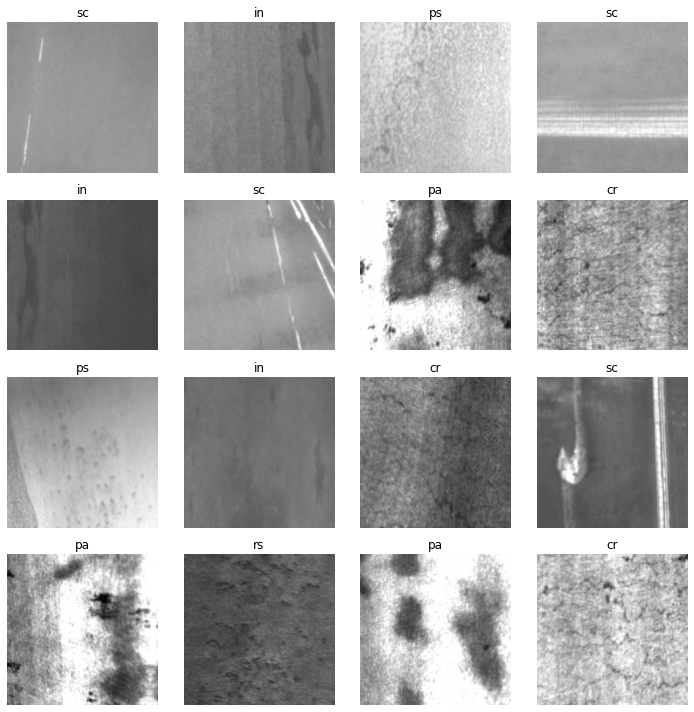

In [14]:
data.show_batch(rows=4, figsize=(10,10))

## model building: stage 1

In [6]:
from torchvision.models import resnet34      #resnet50

precision = Precision()
recall = Recall()
metrics = [accuracy,precision,recall]
learn = cnn_learner(data, resnet34, pretrained=True, metrics=metrics)

In [7]:
learn.model

## see the extra layers towards the very end
'''
(1): Sequential(
    (0): AdaptiveConcatPool2d(
      (ap): AdaptiveAvgPool2d(output_size=1)
      (mp): AdaptiveMaxPool2d(output_size=1)
    )
    (1): Flatten()
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=512, out_features=6, bias=True)
  )
)
'''

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [16]:
#learn.summary()
print(datetime.now())

2020-03-13 18:38:52.438629


In [17]:
# learn with default model + extra 1 layer
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,1.065255,0.161832,0.937037,0.942982,0.936996,00:14
1,0.486191,0.114582,0.962963,0.966693,0.964209,00:12
2,0.301810,0.024552,0.985185,0.985920,0.985343,00:12
3,0.233974,0.033863,0.977778,0.978819,0.977921,00:12


d:\install_loc\anaconda3\envs\fastai2\lib\site-packages\fastai\metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


In [18]:
print(datetime.now())

2020-03-13 18:39:44.431083


In [19]:
# save the basic Resnet34 model
learn.save('resnet34_epc4_stage-1')  
learn.export(model_save_path/'resnet34_epc4_stage-1.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'ml\\train\\ml\\train\\models\\resnet34_epc4_stage-1.pkl'

In [20]:
learn.export('resnet34_epc4_stage-1.pkl')

In [32]:
learn.export("./models/resnet34_epc4_stage-1.pkl")

In [ ]:
###############    stage 1 model performance    ################

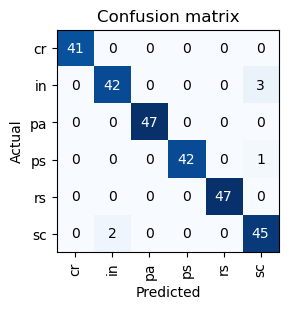

In [21]:
#preds,y,losses = learn.get_preds(with_loss=True)
#interp = ClassificationInterpretation(learn, preds, y, losses)

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(3,3), dpi=100)

In [26]:
interp.most_confused()

[('in', 'sc', 3), ('sc', 'in', 2), ('ps', 'sc', 1)]

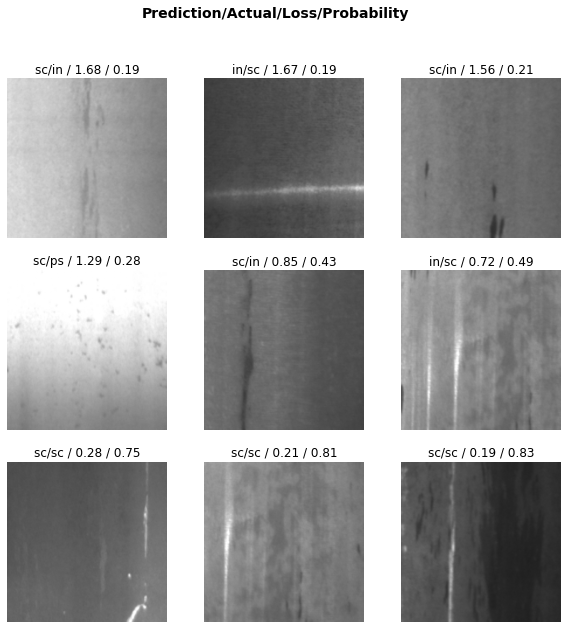

In [27]:
# plot images with the highest loss (biggest mistake)
interp.plot_top_losses(9, figsize=(10,10))
# interp.plot_top_losses(9,heatmap=True, figsize=(7,8))

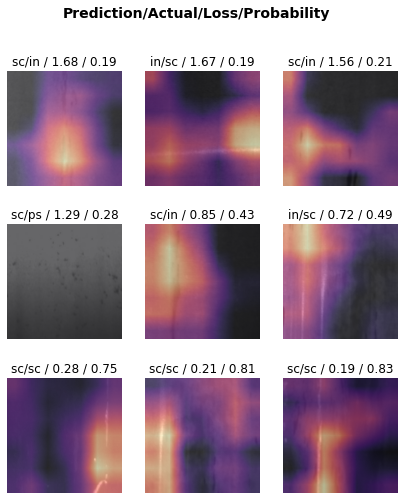

In [28]:
interp.plot_top_losses(9,heatmap=True, figsize=(7,8))

In [29]:
# https://forums.fast.ai/t/path-of-images-corresponding-to-top-losses/30506

interp.top_losses(9)

torch.return_types.topk(
values=tensor([1.6774, 1.6710, 1.5642, 1.2902, 0.8504, 0.7155, 0.2835, 0.2114, 0.1870]),
indices=tensor([182,  86, 129, 122, 148, 151, 120, 103,  73]))

In [30]:
losses,idxs = interp.top_losses(9)   # indices of wrongly predicted images
data.valid_ds.x.items[idxs]

array([WindowsPath('ml/train/in/In_255.bmp'), WindowsPath('ml/train/sc/Sc_98.bmp'),
       WindowsPath('ml/train/in/In_2.bmp'), WindowsPath('ml/train/ps/PS_233.bmp'),
       WindowsPath('ml/train/in/In_286.bmp'), WindowsPath('ml/train/sc/Sc_93.bmp'),
       WindowsPath('ml/train/sc/Sc_3.bmp'), WindowsPath('ml/train/sc/Sc_95.bmp'),
       WindowsPath('ml/train/sc/Sc_130.bmp')], dtype=object)

## Stage 2: unfreezing the model

In [33]:
#### stage 2: learn some more after unfreezing
learn.unfreeze()

In [34]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.268202,0.194074,0.951852,0.956266,0.950961,00:14
1,0.540546,0.192951,0.959259,0.962739,0.959138,00:13
2,0.392099,0.002143,1.000000,1.000000,1.000000,00:13
3,0.251465,0.003305,1.000000,1.000000,1.000000,00:13


In [35]:
#learn.export(model_save_path/'resnet34_epc2_stage-2.pkl')
learn.export('./model/resnet34_epc4_stage-2.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'ml\\train\\model\\resnet34_epc4_stage-2.pkl'

In [36]:
learn.save('resnet34_epc4_stage-2')

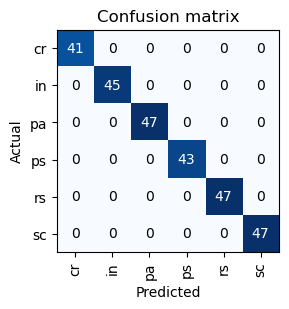

In [37]:
### model interpretation
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(3,3), dpi=100)  # wrong predictions for crack reduce at the cost of no crack

AttributeError: 'Learner' object has no attribute 'losses'

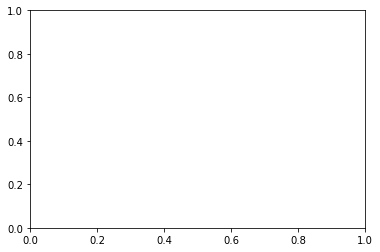

In [38]:
learn.recorder.plot_losses()

## Stage 3: changing learning rates

In [39]:
learn.load("resnet34_epc4_stage-1")

Learner(data=ImageDataBunch;

Train: LabelList (630 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
cr,cr,cr,cr,cr
Path: ml\train;

Valid: LabelList (270 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
ps,cr,pa,cr,ps
Path: ml\train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU

In [40]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision,recall,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [ ]:
learn.recorder.plot(suggestion=True)

In [ ]:
learn.unfreeze()
#learn.fit_one_cycle(4)
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

In [ ]:
## model interpretation

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(3,3), dpi=100)  # wrong predictions for crack reduce at the cost of no crack

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.export(model_save_path/'resnet34__epc2_stage-3.pkl')
learn.save('resnet34_nocrk6000_epc2_stage-3')

##  CHECK PERFORMANCE ON NEW IMAGES

In [ ]:
# level 3 model
learn = load_learner(model_save_path, "resnet34_epc2_stage-3.pkl")

In [ ]:
# predicting on a separate set, with labeled data
test_directory = './ml/test/'   #'/content/gdrive/My Drive/Bridge_Crack_Image_Data-master/test/'
# need to use single quotes in the above command; double quote gave I/O error

images = os.listdir(test_directory)

In [ ]:
from fastai.vision import image
pred = []

In [ ]:
print(datetime.now())

for i in images:
    img = image.open_image(test_directory+i)   # NameError: name 'image' is not defined  if image is not imported
    pred_class,pred_idx,outputs = learn.predict(img)
    pred.append(str(pred_class))

print(datetime.now())

In [ ]:
actual = []

'''
'Crazing'  -> Cr
'Inclusion'   ->  In
'Pitted Surface'  -> PS
'Patches'  -> Pa
'Rolled-in-scale'  ->  RS
'Scratches' -> Sc
'''

for item in os.listdir(test_directory):
    if 'Cr' in item:
        actual.append('cr')   # crazing
    if 'In' in item:
        actual.append('in')
    if 'PS' in item:
        actual.append('ps')   # crazing
    if 'Pa' in item:
        actual.append('pa')
    if 'RS' in item:
        actual.append('rs')   # crazing
    if 'Sc' in item:
        actual.append('sc')

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

class_names = ['crazing','inclusion','patches','pittedSurface','rolled-in-scale','scratches']
print(classification_report(actual, pred, target_names=class_names))

In [ ]:
confusion_matrix(actual,pred,labels=class_names)

In [ ]:
accuracy_score(actual, pred)

In [ ]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cnf_matrix = confusion_matrix(actual, pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
